#  Q-learning

__Автор задач: Блохин Н.В. (NVBlokhin@fa.ru)__

Материалы:
* Саттон Р.	С.,	Барто Э. Дж. Обучение с подкреплением: Введение. 2-е изд.
* https://en.wikipedia.org/wiki/Q-learning
* https://pythonprogramming.net/q-learning-reinforcement-learning-python-tutorial/
* https://pytorch.org/tutorials/intermediate/reinforcement_q_learning.html
* https://github.com/pylSER/Deep-Reinforcement-learning-Mountain-Car/tree/master
* https://valohai.com/blog/reinforcement-learning-tutorial-basic-deep-q-learning/

## Задачи для совместного разбора

1\. Обсудите основные отличия DQN от классических вариантов Q-learning.

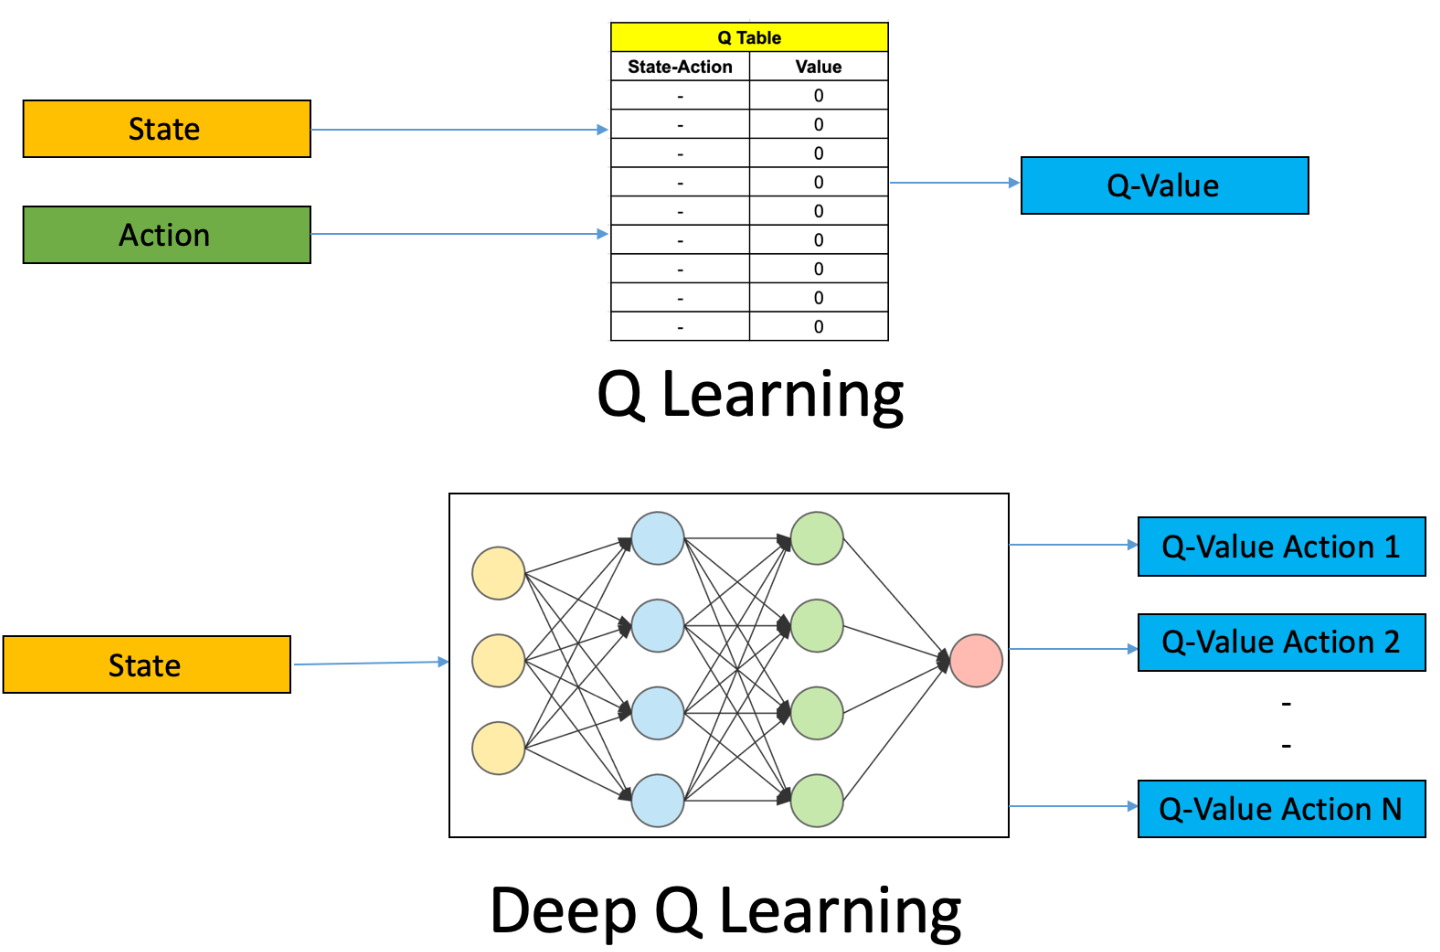

<img src="https://valohai.com/blog/reinforcement-learning-tutorial-part-1-q-learning/image4.png" width="500">
<img src="https://valohai.com/blog/reinforcement-learning-tutorial-basic-deep-q-learning/4.png" width="500">


## Задачи для самостоятельного решения

<p class="task" id="1"></p>

1\. Допишите класс `ReplayMemory` для хранения переходов между состояниями.

- [x] Проверено на семинаре

In [ ]:
from collections import namedtuple, deque
import random

Transition = namedtuple(
    'Transition',
    ('state', 'action', 'next_state', 'reward', 'done')
)

class ReplayMemory(object):
    def __init__(self, capacity):
        """capacity - максимальный размер хранилища"""
        self.dq = deque([], maxlen=capacity)

    def push(self, args):
        """Сохраняет переход. При нехватке места в хранилище самые старые записи удаляются."""
        self.dq.append(Transition(*args))


    def sample(self, batch_size):
        """Возвращает batch_size случайно выбранных переходов"""
        return random.choices(self.dq, k=batch_size)

    def __len__(self):
        len(self.dq)

In [ ]:
rm = ReplayMemory(15)
example1 = Transition(0, 1, 3, 0, False)
example2 = Transition(9, 6, 1, 0, False)
rm.push(example1)
rm.push(example2)
rm.sample(5)

[Transition(state=9, action=6, next_state=1, reward=0, done=False),
 Transition(state=0, action=1, next_state=3, reward=0, done=False),
 Transition(state=9, action=6, next_state=1, reward=0, done=False),
 Transition(state=0, action=1, next_state=3, reward=0, done=False),
 Transition(state=9, action=6, next_state=1, reward=0, done=False)]

In [ ]:
rm.dq

deque([Transition(state=0, action=1, next_state=3, reward=0, done=False),
       Transition(state=9, action=6, next_state=1, reward=0, done=False)])

<p class="task" id="2"></p>

2\. Допишите класс `DQN` для моделирования Q-функции.

- [x] Проверено на семинаре

In [ ]:
import torch.nn as nn
class DQN(nn.Module):
  """Нейронная сеть для моделирования Q-функции."""
  def __init__(self, n_observations, n_actions):
    super().__init__()
    self.fc1 = nn.Linear(in_features=n_observations, out_features=20)
    self.fc2 = nn.Linear(in_features=20, out_features=n_actions)
    self.relu = nn.ReLU()

  def forward(self, x):
    """Для каждого состояния должны получать n_actions чисел."""
    out = self.fc1(x)
    out = self.relu(out)
    out = self.fc2(out)
    return out

<p class="task" id="3"></p>

3\. Допишите классы `PolicyConfig` для настроек политики агента и `Policy` для реализации политики.

- [ ] Проверено на семинаре

In [ ]:
from dataclasses import dataclass
import torch as th

@dataclass
class PolicyConfig:
    """Содержит настройки для Policy: размерность пространства наблюдений, кол-во действий,
    устройство, на котором будет располагаться модели; ε и т.д."""
    n_observations: int = 5
    n_actions: int = 3
    if th.cuda.is_available():
        device =  th.device('cuda')
    else:
        device =  th.device('cpu')
    eps: float = 0.1

In [ ]:
class Policy:
  def __init__(self, policy_cfg: PolicyConfig):
      self.policy_network = DQN(policy_cfg.n_observations, policy_cfg.n_actions) # эту версию используем для обучения на каждом шаге
      self.policy_network.to(device=policy_cfg.device)
      self.target_network = DQN(policy_cfg.n_observations, policy_cfg.n_actions) # эту версию используем для прогноза на каждом шаге
      self.target_network.to(device=policy_cfg.device)
      self.sync_models()
      self.cfg = policy_cfg

  def sync_models(self):
      # загрузите веса из модели self.policy_network в self.target_network
      self.target_network.load_state_dict(self.policy_network.state_dict())

  def get_best_action(self, state: th.Tensor) -> int:
      # реализуйте ε-жадную стратегию выбора
      p = np.random.uniform(0, 1)
      if p < self.cfg.eps:
        return np.random.choice(np.arange(self.cfg.n_actions))
      else:
        return self.policy_network(state).argmax().item()

  def save(self, path):
      # метод для сохранения моделей на диск
      th.save(self.policy_network.state_dict(), path)

  def load(self, path):
      # метод для сохранения моделей с диска
      self.policy_network = th.load(path)
      self.sync_models()

<p class="task" id="4"></p>

4\. Напишите функцию `plot_metrics`, которая будет использоваться для визуализации процесса обучения: суммарной награды за каждый эпизод и максимальное значение x-координаты машины за эпизод. Для реализации можете воспользоваться `tensorboard` или любым другим удобным инструментом.

- [ ] Проверено на семинаре

In [ ]:
import matplotlib.pyplot as plt
def plot_metrics(dct):
    fig, ax = plt.subplots(ncols=2)
    for i, (title, vals) in enumerate(dct.items()):
        ax[i].plot(vals)
        ax[i].set_title(title)
    plt.show()

<p class="task" id="5"></p>

5\. Допишите классы `TrainConfig` для настроек обучения и `Trainer` для реализации процесса обучения.

- [ ] Проверено на семинаре

In [ ]:
@dataclass
class TrainConfig:
    """Содержит настройки для процесса обучения: к-т дисконтирования, скорость обучения,
    количество эпизодов для обучения, размер батча и т.д."""
    discount: float = 0.95
    lr: float = 0.005
    n_episodes: float = 100
    epsilon: float = 0.1
    final_epsilon: float = 0.3
    print_every: int = 5000
    gamma: float =  0.95
    batch_size: int = 120

In [ ]:
!pip install gymnasium

In [ ]:
import gymnasium as gym
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
import numpy as np
import gymnasium as gym

import gymnasium as gym

class Trainer:
    def __init__(self, env: gym.Env, train_config: TrainConfig, policy: Policy):
        # создайте критерий и оптимизатор для настройки модели policy.policy_network
        # создайте объект для хранения переходов
        self.memory = ReplayMemory(1024)
        self.policy = policy
        self.env = env
        self.cfg = train_config
        self.optimizer = optim.Adam(policy.policy_network.parameters(), lr=self.cfg.lr)
        self.crit = nn.MSELoss()
        self.metrics = {
            'reward': [],
            'max_position': []
        }

    def train(self):
        # метод для старта обучения
        # - итерация по эпизодам (run_episode)
        # - сохранение метрик за эпизод
        # - визуализация
        # - сохранение модели при улучшении качества (максимального значения по оси x, которого удалось достичь)
        rewards = 0
        for ep in tqdm(range(self.cfg.n_episodes)):
          state, info = self.env.reset()
          rew, max_pos = self.run_episode(state)
          self.metrics['reward'].append(rew)
          self.metrics['max_position'].append(max_pos)


    def run_episode(self, start_state: th.Tensor):
        # метод для прогона эпизода
        # - генерация переходов и их сохранение
        # - запуск генерации батча и обучения (generate_batch_and_fit)
        # - синхронизация моделей (policy и target) - не обязательно на каждом шаге
        # не забудьте уменьшить ε в процессе обучения
        max_position = -99
        reward_sum = 0
        done = False
        state, info = self.env.reset()
        while not done:
          action = self.policy.get_best_action(th.tensor(state))
          new_state, reward, terminated, truncated, info = self.env.step(action)
          if new_state[0] > max_position:
            max_position = new_state[0]
          if new_state[0] > -0.2:
            reward += 10
          t = Transition(state, action, new_state, reward, done)
          self.memory.push(t)
          done = terminated or truncated
          state = new_state
          reward_sum += reward
          self.generate_batch_and_fit()

          if done:
            self.policy.sync_models()
            self.policy.cfg.eps = max(self.policy.cfg.min_eps,
                                      self.policy.cfg.eps - self.policy.cfg.eps_decay)
            return reward_sum, max_position

    def generate_batch_and_fit(self):
        # генерируем батч на основе хранилища
        transitions = self.memory.sample(self.cfg.batch_size)
        # получаем набор текущих состояний и следующих состояний
        states = np.array([trans.state for trans in transitions])
        next_states = np.array([trans.new_state for trans in transitions])

        # получаем прогнозы для текущих состояний и следующих состояний
        targets = self.policy.policy_network(th.tensor(states)).detach().numpy()
        next_state_targets = self.policy.target_network(th.tensor(next_states)).detach().numpy()

        # модифицируем targets: если сессия закончена, то targets[t.action] = t.reward
        # если нет, то targets[t.action] = t.reward + gamma * max(next_state_targets[i])
        # t - переход из батча с номером i
        for i, sample in enumerate(transitions):
            state, action, new_state, reward, done = sample
            target = targets[i]
            if done:
                target[action] = reward
            else:
                target[action] = reward + self.cfg.gamma * max(next_state_targets[i])

        # вызываем fit_policy_network
        self.fit_policy_network(th.tensor(states), th.tensor(targets))

    def fit_policy_network(self, X, y):
        # напишите код для обучения модели
        # X - батч состояний (batch_size x 2)
        # y - набор Q-значений (batch_size x 3)
        out = self.policy.policy_network(X)
        loss = self.crit(out, y)
        loss.backward()
        self.optimizer.step()
        self.optimizer.zero_grad()

<p class="task" id="6"></p>

6\. Настройте модель для управления машиной в окружении `MountainCar-v0`. Для преобразования векторов состояний в тензоры используйте обертку `TransformObservation`. Выведите на экран график с информацией о процессе обучения. При необходимости вставьте скриншоты этих графиков.

- [ ] Проверено на семинаре

In [ ]:
env = gym.make('MountainCar-v0')
pol = Policy(PolicyConfig())
car = Trainer(env, TrainConfig(), pol)

car.train()

  0%|          | 0/100 [00:00<?, ?it/s]


RuntimeError: ignored

In [ ]:
plot_metrics(car.metrics)

<p class="task" id="7"></p>

7\. Загрузите состояния моделей из файлов, которые были получены в процессе обучения. Создайте окружение и сыграйте эпизод, используя стратегию, выведенную из обученной Q-функции.

- [ ] Проверено на семинаре

## Обратная связь
- [ ] Хочу получить обратную связь по решению